**1. Brief Description of the Problem and Data:**

This Kaggle challenge ("Natural Language Processing with Disaster Tweets") requires natural language processing (NLP) for the purpose of analyzing tweets. These tweets may or may not be describing or alerting about a natural disaster. The challenge provides a training set and testing set; the training set includes binary target labels (1="disaster", 0="not disaster").
The training set contains $7,613$ entries. The balance of responses is asymmetric, with more tweets labeled as "not disaster" (57%). The following code blocks explore the training set and its characteristics. 


In [1]:
#Importing the necessary packages
import os
import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#Loading the train and test sets.
train_data = pd.read_csv('/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv')
test_data = pd.read_csv('/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv')

In [4]:
#Exploratory data analysis
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#Taking a quick look at some of the key characteristics of the data; only the target variable here reveals anything.
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


**2. Exploratory Data Analysis:**

The following code blocks explore the data more thoroughly, examining the type of text present, the characteristics of relevant variables, and the distribution of labels (via histogram).

In [6]:
#Which types of words are used? What kinds of characters/misspellings/conjunctions/abbreviations should we expect?
train_data.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [7]:
#When I printed the data sets above I noticed a lot of NAs. Is this going to be a problem for the analysis, limiting the usefulness of some variables?
print('Out of',len(train_data.keyword), 'values in the keyword column,', len(train_data.keyword[~pd.isna(train_data.keyword)]), 'are NA')
print('Out of',len(train_data.location), 'values in the keyword column,', len(train_data.location[~pd.isna(train_data.location)]), 'are NA')

Out of 7613 values in the keyword column, 7552 are NA
Out of 7613 values in the keyword column, 5080 are NA


In [8]:
#Thus the 'location' and 'keyword' columns probably won't be too helpful, so we'll need to focus on the actual text for our model. 
#Removing 'location' and 'keyword' columns.
train_red = train_data.drop(['keyword', 'location'], axis=1)
train_red.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
#Dropping these columns from the test data as well.
test_red = test_data.drop(['keyword', 'location'], axis=1)
test_red.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


Text(0.5, 1.0, 'Frequency of Natural Disasters')

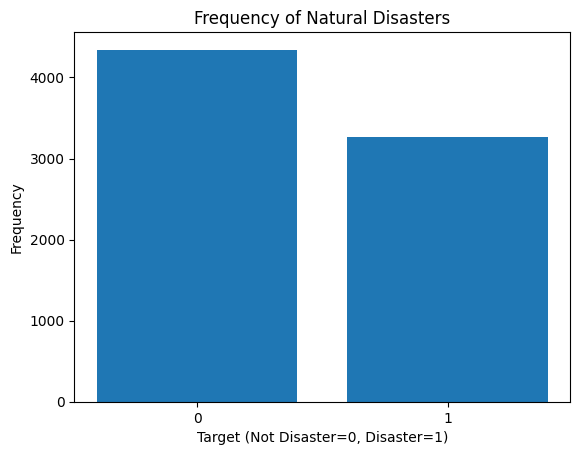

In [10]:
#Checking the distribution of labels in the training data.
fig, ax = plt.subplots()
#train_data_targets = np.sum(train_data.target==1)/len(train_data)
ax.hist(train_red.target, bins=2, density=False, rwidth=0.8)
ax.set_xticks([0.25, 0.75], ['0','1'])
ax.set_xlabel('Target (Not Disaster=0, Disaster=1)')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Natural Disasters')

In [11]:
print('Percentage of disasters in the training data:', 
      np.round(np.sum(train_red.target[train_red.target==1])/len(train_red),2))
print('Percentage that were not disasters in the training data', 
      np.round((len(train_red) - np.sum(train_red.target[train_red.target==1]))/len(train_red),2))

Percentage of disasters in the training data: 0.43
Percentage that were not disasters in the training data 0.57


**3. Model Architecture:**

The model will need to be able to interpret text data to understand, learn, and predict which are indicative of actual disasters. Text strings can continue a lot of meaningless, filler, or connecting values; thus the first step will be to identify 'important' or meaningful words in the text entries and strip out the rest.

The architecture used to build the model will therefore include the following processes and steps:
1. Tokenization of the text to enable its interpretation in a neural network;
2. Creating a full corpus from which to work (by combining all text messages, and then seeing which texts have which specific text elements);
3. Removal of stop words, as a basic process for improving the semantic template;
4. Transformation of text into numeric sequences for the purpose of model heuristics;
5. Construction of a sequential model. An embedding layer that accounted for the dimensions of the word index was added, an LSTM layer, a dense layer after the LSTM layer, and finally an output layer that used the sigmoid activation function, which is common for binary outputs (in this case, "disaster" vs. "not disaster").
6. Training the model on the training set over $10$ epochs, with batch size $32$.

In [12]:
#Defining the stop words that will be filtered out.

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [13]:
#Creating a function to filter the stop words for each entry.
from nltk.tokenize import word_tokenize

def rem_stop_words(data, stop_words):
    new_text_body = []
    for i in range(len(data)):
        tokens = word_tokenize(data[i])
        imp_words = [word for word in tokens if word.lower() not in stop_words]
        new_text_body.append(imp_words)
    return new_text_body

In [14]:
#Now applying the function to the training data.
new_text_body = rem_stop_words(data=train_red.text, stop_words=stop_words)

In [15]:
#Creating a function that will generate a full text corpus from which the important values will be identified.
def create_text_body(data):
    text_body = []
    for i in range(len(data)):
        comment = data[i]
        text_body.append(comment)
    return text_body

In [16]:
#Using the above function to create the corpus of text for the problem.
text_body = create_text_body(new_text_body)

In [17]:
#Need to tokenize the text for analysis, and then convert it into sequences for the model to analyze.
tokenizer = Tokenizer()

#Fitting the tokenizer to the training corpus.
tokenizer.fit_on_texts(text_body)

#Now transforming the text to integer sequences with which the neural network can work.
sequences = tokenizer.texts_to_sequences(text_body)
#print(sequences)

In [18]:
#Taking a look at the words as a quick check.
word_index = tokenizer.word_index
#print(word_index)

In [19]:
#Padding the sequences to make them the same length for analysis.
max_len = 10  #Arbitrary
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
print(padded_sequences)

[[ 4406   738     3 ...    41     0     0]
 [  120    21   160 ...  1085     0     0]
 [  567    11  6749 ...   567  1261  1029]
 ...
 [ 1459    36     4 ...     2     1  6708]
 [ 5228     5  3032 ...  2452   224     5]
 [  447   124    44 ...     2     1 23078]]


In [20]:
import tensorflow as tf

In [21]:
#Leaving here for iteration and tweaking of the model's hyperparameters.
#tf.keras.backend.clear_session()

In [21]:
#Building the model using the architecture described above.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

#Setting the architecture
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1, 100, input_length=max_len))  
model1.add(LSTM(128)) #was 128
#model1.add(Dense(1024, activation='sigmoid')) #New layer. Didn't do much.
model1.add(Dense(1, activation='sigmoid')) 

#Compiling
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'f1_score'])

#Training
model1.fit(padded_sequences, train_data.target, epochs=10, batch_size=32) #Tried a variety, sticking with this as nothing improved.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6699 - f1_score: 0.5984 - loss: 0.5978
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8927 - f1_score: 0.6060 - loss: 0.2835
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9564 - f1_score: 0.6037 - loss: 0.1253
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9798 - f1_score: 0.5950 - loss: 0.0574
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9863 - f1_score: 0.6019 - loss: 0.0423
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9886 - f1_score: 0.5972 - loss: 0.0279
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9895 - f1_score: 0.6092 - loss: 0.0219
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9924 - f1_score: 0.6010 - loss: 0.0174
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9924 - f1_score: 0.6051 - loss: 0.0199
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20

**4. Results and Analysis:**

**a) Discussion of Results from the First Model:**

Running the model before and after removing stop words, and before and after adding an intermittent layer, resulted in high accuracy (0.99) but an f1-score hovering around 0.6. One possible option would be to go back to the beginning and examine whether the words of any text are mentioned in that highly suggestive 'keyword' column which was removed because there were so few entries. In these next code blocks that's what I'll do, and we'll see whether focusing on the frequency or appearance of keywords improves the model's performance.


In [22]:
#Nan is the first value in the unique keyword array; eliminating it to create a list of useful words.
useful_keywords = train_data.keyword.unique()[1:]
print(type(useful_keywords))
useful_keywords = set(useful_keywords.astype(str))

#Function to replace the '%20' (or anything else that pops up) from the strings, to allow comparison and remove meaningless characters.
def repl_str(prev, repl):
    new_keywords = set()
    for word in prev:
        for old, new in repl.items():
            word = word.replace(old, new)
        new_keywords.add(word)
    return new_keywords

repl_dct = {'%20': ' '}
new_keywords = repl_str(useful_keywords, repl_dct)

<class 'numpy.ndarray'>


In [23]:
#Here are our new keywords:
print(new_keywords)

{'smoke', 'fire truck', 'cyclone', 'derailment', 'deaths', 'deluged', 'outbreak', 'natural disaster', 'nuclear reactor', 'panic', 'oil spill', 'bomb', 'radiation emergency', 'bioterrorism', 'drought', 'buildings on fire', 'tragedy', 'rescued', 'disaster', 'eyewitness', 'stretcher', 'explode', 'forest fire', 'blood', 'wildfire', 'wounded', 'violent storm', 'screamed', 'burning', 'crush', 'chemical emergency', 'obliteration', 'desolate', 'thunder', 'mass murderer', 'displaced', 'demolished', 'engulfed', 'ruin', 'hijack', 'trapped', 'wreckage', 'blew up', 'bombing', 'collide', 'danger', 'screams', 'catastrophe', 'exploded', 'ambulance', 'deluge', 'traumatised', 'quarantine', 'obliterated', 'burned', 'typhoon', 'crushed', 'hellfire', 'weapons', 'attack', 'flooding', 'drowned', 'evacuate', 'damage', 'destruction', 'emergency services', 'harm', 'riot', 'forest fires', 'twister', 'derailed', 'terrorism', 'evacuation', 'pandemonium', 'arsonist', 'suicide bomb', 'hostages', 'inundated', 'quaran

In [24]:
#Modifying earlier function to focus on keywords:
def keep_keywords(data, keep_words):
    new_text_body = []
    for i in range(len(data)):
        tokens = word_tokenize(data[i])
        imp_words = [word for word in tokens if word.lower() in keep_words]
        new_text_body.append(imp_words)
    return new_text_body

In [25]:
#Now calling the function to focus on those words:
keyword_textbody = keep_keywords(data=train_red.text, keep_words=new_keywords)

In [26]:
#Tokenizing, fitting to texts, and generating sequences
kwrd_text_body = create_text_body(keyword_textbody)

tokenizer2 = Tokenizer()

tokenizer2.fit_on_texts(kwrd_text_body)

sequences2 = tokenizer2.texts_to_sequences(kwrd_text_body)
#print(sequences2)

In [27]:
#Padding the sequences.
padded_sequences2 = pad_sequences(sequences2, maxlen=max_len, padding='post')
print(padded_sequences2)

[[ 29   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [ 26   0   0 ...   0   0   0]
 ...
 [148   0   0 ...   0   0   0]
 [  4  46  35 ...   0   0   0]
 [134  14   0 ...   0   0   0]]


In [29]:
word_index2 = tokenizer2.word_index

In [30]:
#Setting the architecture
model2 = Sequential()
model2.add(Embedding(len(word_index2) + 1, 100, input_length=max_len))  
model2.add(LSTM(128))
model2.add(Dense(1, activation='sigmoid')) 

#Compiling
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'f1_score'])

#Training
model2.fit(padded_sequences2, train_data.target, epochs=10, batch_size=32)

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6128 - f1_score: 0.6078 - loss: 0.6529
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7225 - f1_score: 0.6034 - loss: 0.5552
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7314 - f1_score: 0.6073 - loss: 0.5487
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7433 - f1_score: 0.6047 - loss: 0.5305
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7410 - f1_score: 0.6049 - loss: 0.5321
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7372 - f1_score: 0.5933 - loss: 0.5356
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7380 - f1_score: 0.6021 - loss: 0.5341
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7383 - f1_score: 0.6000 - loss: 0.5323
Epoch 9/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7390 - f1_score: 0.6032 - loss: 0.5263
Epoch 10/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12

**4. Results and Analysis (continued):**

**b) Discussion of Results from the Second Model:**

There was a steep drop in accuracy without much improvement in f1-score. Keeping with the first model.

**c) Applying the first model to the test data and generating output:**

To apply the model, I'll first prepare the test data for analysis using the functions I implemented above: rem_stop_words (to remove stop words from the test data), create_text_body (to create a corpus for analysis), and package-provided fit_on_texts, texts_to_sequences, and pad_sequences. Then the model will generate predictions of disaster or not based on the provided text>

From there, I'll output the predictions into a .csv file and submit it to the competition. 

In [35]:
#Predicting with test data set. Following the above steps to prepare the test data, and then applying the model:
test_text_body = rem_stop_words(data=test_red.text, stop_words=stop_words)
 
new_test_text_body = create_text_body(test_text_body)

tokenizer.fit_on_texts(new_test_text_body)

test_sequences = tokenizer.texts_to_sequences(new_test_text_body)

padded_test_seqs = pad_sequences(test_sequences, maxlen=max_len, padding='post')

y_preds = model1.predict(padded_test_seqs)
output = (y_preds<0.5).astype(int)
#print(output)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [36]:
#Preparing the predictions for the output file.
output_vals = []
for i in range(len(output)):
    val = output[i][0]
    output_vals.append(val)

In [37]:
#Creating the submission file.
submission = pd.DataFrame({'id': test_data.id, 'target':output_vals})
print(submission.head())
submission.to_csv('submission.csv', index=False)

   id  target
0   0       1
1   2       0
2   3       1
3   9       0
4  11       1


**5. Conclusion**

The model used sequential layers with embeddings, LSTM, and an output layer that featured the sigmoid activiation function. While the model was able to achieve excellent accuracy on the training data, the f1-score continued to hover around $0.6$, even after numerous adjustments to the hyperparameters. One final adjustment was made in the processing of data, i.e., leveraging disaster-related keywords to help the model learn which words would be more likely to be associated with disasters; contrary to expectations, this approach actually decreased the accuracy while maintaining similar f1-scores, and was not used in the final model.

Alternative approaches and methods for interpreting text data for deep learning models exist and will likely be attempted as part of an iterative process of improving f1-scores for this challenge.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/natural-language-processing-with-disaster-tweets/sample_submission.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/train.csv
/kaggle/input/natural-language-processing-with-disaster-tweets/test.csv
